In [1]:
import numpy as np
from numpy.typing import NDArray
from sklearn.utils import check_random_state

from src.generators.base import BaseGenerator


class SyntheticWithSupplierGenerator(BaseGenerator):
    def __init__(
        self,
        n_query: int,
        n_sup: int,
        mean_n_item_per_sup: float = 1.0,
        lam: float = 0.0,
        flip_ratio: float = 0.3,
        noise: float = 0.0,
        random_state: int = 12345,
    ) -> None:
        self.n_query = n_query
        self.n_sup = n_sup
        self.mean_n_item_per_sup = mean_n_item_per_sup
        self.lam = lam
        self.flip_ratio = flip_ratio
        self.noise = noise
        self.random_state = random_state

        assert mean_n_item_per_sup > 1, "mean_n_item_per_sup must be greater than 1"

    def generate_rel_mat(self) -> tuple[NDArray[np.float_], NDArray[np.float_]]:
        return self.synthesize_rel_mat(
            self.n_query,
            self.n_sup,
            self.mean_n_item_per_sup,
            self.lam,
            self.flip_ratio,
            self.noise,
            self.random_state,
        )

    @staticmethod
    def synthesize_rel_mat(
        n_query: int,
        n_sup: int,
        mean_n_item_per_sup: float,
        lam: float = 0.0,
        flip_ratio: float = 0.3,
        noise: float = 0.0,
        random_state: int = 12345,
    ) -> tuple[NDArray[np.float_], NDArray[np.float_]]:
        """
        Synthesizes a relevance matrix for query-document pairs.

        This function generates a synthetic relevance matrix for a given number of queries and documents.
        The relevance matrix represents the relevance scores between each query and document pair.
        The generated matrix can be used for evaluating ranking algorithms.

        Args:
            n_query (int): The number of queries.
            n_sup (int): The number of suppliers.
            mean_n_item_per_sup (float): The mean number of items per supplier.
            lam (float, optional): The weight parameter for combining the true relevance matrix and the popularity-based matrix. Defaults to 0.0.
            flip_ratio (float, optional): The ratio of documents to flip the relevance scores. Defaults to 0.3.
            noise (float, optional): The amount of noise to add to the relevance scores. Defaults to 0.0.
            random_state (int, optional): The random seed for reproducibility. Defaults to 12345.

        Returns:
            tuple[NDArray[np.float_], NDArray[np.float_]]: A tuple containing the true relevance matrix and the observed relevance matrix.
                The true relevance matrix represents the ground truth relevance scores between each query and document pair.
                The observed relevance matrix represents the noisy version of the true relevance matrix, with optional flipping and noise.

        References:
            - This function is adapted from `synthesize_rel_mat` at [https://github.com/usaito/kdd2022-fair-ranking-nsw/blob/main/src/synthetic/func.py) by yuta-saito.
            - MIT License, Copyright (c) 2022 yuta-saito. See the original repository for full license information.
        """
        random_ = check_random_state(random_state)

        # generate number of items per supplier
        # 最小値が1になるように平均値から1を引いてサンプリング後に1を足す。期待値はmean_n_item_per_sup
        n_item_per_sup = np.random.poisson(lam=mean_n_item_per_sup - 1, size=n_sup) + 1
        n_doc = n_item_per_sup.sum()
        sup = np.repeat(np.arange(n_sup), n_item_per_sup)

        # generate true relevance matrix
        rel_mat_unif = random_.uniform(0.0, 1.0, size=(n_query, n_doc))
        rel_mat_pop_sup = np.ones((n_query, n_sup))
        rel_mat_pop_sup -= (np.arange(n_sup) / n_sup)[np.newaxis, :]
        rel_mat_pop_doc = rel_mat_pop_sup.repeat(n_item_per_sup, axis=1)
        rel_mat_pop_query = np.ones_like(rel_mat_unif)
        rel_mat_pop_query -= (np.arange(n_query) / n_query)[:, np.newaxis]
        rel_mat_pop = rel_mat_pop_doc * rel_mat_pop_query
        rel_mat_pop *= rel_mat_unif.sum() / rel_mat_pop.sum()
        rel_mat_true = (1.0 - lam) * rel_mat_unif
        rel_mat_true += lam * rel_mat_pop

        # flipping
        flip_docs = random_.choice(
            np.arange(n_doc), size=np.int32(flip_ratio * n_doc), replace=False
        )
        flip_docs.sort()
        rel_mat_true[:, flip_docs] = rel_mat_true[::-1, flip_docs]

        # gen noisy relevance matrix
        if noise > 0.0:
            rel_mat_obs = np.copy(rel_mat_true)
            rel_mat_obs += random_.uniform(-noise, noise, size=(n_query, n_doc))
            rel_mat_obs = np.maximum(rel_mat_obs, 0.001)
        else:
            rel_mat_obs = rel_mat_true

        # 提供者毎のアイテム数をポアソン分布から生成
        n_item_per_sup = np.random.poisson(lam=1.0, size=n_query)

        return rel_mat_true, rel_mat_obs, sup

In [2]:
from typing import Optional

import japanize_matplotlib  # noqa: F401
import numpy as np
import torch
import torch.nn as nn
from numpy.typing import NDArray
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from src.optimizers._ot_utils import sinkhorn


def aggregate_by_sup_torch(x: torch.Tensor, sup: torch.Tensor):
    sup_size = int(sup.max().item() + 1)
    out = torch.zeros(sup_size, device=x.device)
    out.scatter_add_(0, sup, x)
    return out


def compute_nsw_loss(
    pi: torch.Tensor,
    click_prob: torch.Tensor,
    am_rel: torch.Tensor,
    sup: torch.Tensor,
    eps: float = 0,
) -> torch.Tensor:
    """
    Compute the Nash Social Welfare (NSW) loss.

    Args:
        pi (torch.Tensor): Probability matrix of shape (n_query, n_doc, n_rank).
        click_prob (torch.Tensor): Click probability matrix of shape (n_query, n_doc, n_rank).
        am_rel (torch.Tensor): Relevance matrix of shape (n_doc).
        sup (torch.Tensor): Supplier matrix of shape (n_doc).
        eps (float, optional): Small value added to the denominator to avoid division by zero. Defaults to 0.

    Returns:
        torch.Tensor: The computed NSW loss.

    """
    imp = (pi * click_prob).sum(dim=[0, 2])
    # 供給者毎にimpを集計
    imp_sup = aggregate_by_sup_torch(imp, sup)
    return -(am_rel * torch.log(imp_sup + eps)).sum()


def compute_pi_ot_nsw(
    rel_mat: NDArray[np.float_],
    expo: NDArray[np.float_],
    high: NDArray[np.float_],
    sup: NDArray[np.float_],
    alpha: float = 0.0,
    eps: float = 0.01,
    lr: float = 0.01,
    max_iter: int = 200,
    ot_n_iter: int = 30,
    tol: float = 1e-6,
    device: str = "cpu",
    use_amp: Optional[bool] = None,
) -> tuple[NDArray[np.float_]]:
    """_description_

    Args:
        rel_mat (NDArray[np.float_]): relevance matrix. (n_query, n_doc)
        expo (NDArray[np.float_]): exposure matrix. (n_rank, 1)
        high (NDArray[np.float_]): high matrix. (n_doc, )
        alpha (float, optional): alpha. Defaults to 0.0.
        lr (float, optional): learning rate. Defaults to 0.01.
        ot_n_iter (int, optional): number of iteration for ot. Defaults to 30.
        tol (float, optional): tolerance. Defaults to 1e-6.
        device (str, optional): device. Defaults to "cpu".
        pi_stock_size (int, optional): pi stock size. Defaults to 0.
        grad_stock_size (int, optional): grad stock size. Defaults to 0.

    Returns:
        NDArray[np.float_]: _description_
    """
    n_query, n_doc = rel_mat.shape
    n_rank = expo.shape[0]
    rel_mat: torch.Tensor = torch.FloatTensor(rel_mat).to(device)  # (n_query, n_doc)
    expo: torch.Tensor = torch.FloatTensor(expo).to(device)  # (K, 1)
    sup: torch.Tensor = torch.LongTensor(sup).to(device)  # (n_doc, )
    am_rel = rel_mat.sum(0)  # (n_doc, )
    click_prob = rel_mat[:, :, None] * expo.reshape(1, 1, n_rank)  # (n_query, n_doc, K)

    # am_relを供給者毎に集計
    am_rel_sup = aggregate_by_sup_torch(am_rel, sup) ** alpha

    # アイテムからの供給量
    a: torch.Tensor = torch.FloatTensor(high).view(1, -1, 1).to(device)
    # ダミー列への輸送量はアイテム数 - 表示数
    dummy_demand = a.sum(dim=1) - n_rank  # (n_query, 1)
    b = torch.ones(n_query, n_rank + 1, 1, device=device)
    b[:, -1, :] = dummy_demand

    # 初期値は一様分布
    # 表示数 < アイテム数の場合にはダミー列に輸送されるようにする
    C = nn.Parameter(torch.ones(n_query, n_doc, n_rank + 1).to(device))
    optimier = torch.optim.Adam([C], lr=lr)
    if use_amp is None:
        use_amp = True if device == "cuda" else False
    scaler = GradScaler(enabled=use_amp)
    for iter_ in tqdm(range(max_iter), leave=False):
        optimier.zero_grad()
        with autocast(enabled=use_amp):
            # compute X
            X: torch.Tensor = sinkhorn(C, a, b, n_iter=ot_n_iter, eps=eps)
            loss = compute_nsw_loss(X[:, :, :-1], click_prob, am_rel_sup, sup)
        scaler.scale(loss).backward()
        scaler.step(optimier)
        scaler.update()

        grad_norm = torch.norm(C.grad)
        # gradient normが一定以下になったら終了
        if grad_norm < tol:
            break

    pi: NDArray[np.float_] = X[:, :, :-1].detach().cpu().numpy()

    return pi

In [3]:
def aggregate_by_sup(x: NDArray[np.float_], sup: NDArray[np.float_]) -> NDArray[np.float_]:
    """Aggregate the given matrix x by supplier.

    Args:
        x (NDArray[np.float_]): The matrix to be aggregated. (n_doc, )
        sup (NDArray[np.float_]): The supplier matrix. (n_doc, )

    Returns:
        NDArray[np.float_]: The aggregated matrix. (n_sup)
    """
    out_size = int(sup.max() + 1)
    out = np.zeros(out_size, dtype=x.dtype)

    # 供給者毎に集計
    np.add.at(out, sup, x)

    return out

In [4]:
from typing import Optional

import cvxpy as cvx
import numpy as np
from numpy.typing import NDArray


def compute_nsw(
    rel_mat: NDArray[np.float_],
    expo: NDArray[np.float_],
    high: NDArray[np.float_],
    sup: NDArray[np.float_],
    alpha: float = 0,
    solver: Optional[str] = None,
) -> NDArray[np.float_]:
    """_summary_

    Args:
        rel_mat (NDArray[np.float_]): _description_
        expo (NDArray[np.float_]): _description_
        high (NDArray[np.float_]): _description_
        sup (NDArray[np.float_]): _description_
        alpha (float, optional): _description_. Defaults to 0.
        solver (Optional[str], optional): _description_. Defaults to None.

    Returns:
        NDArray[np.float_]: _description_

    References:
        - This function is adapted from `compute_pi_nsw` at [https://github.com/usaito/kdd2022-fair-ranking-nsw/blob/main/src/synthetic/func.py] by yuta-saito.
        - MIT License, Copyright (c) 2022 yuta-saito. See the original repository for full license information.
    """
    n_query, n_doc = rel_mat.shape
    K = expo.shape[0]
    query_basis = np.ones((n_query, 1))
    am_rel = rel_mat.sum(0)
    # am_relを供給者毎に集計
    am_rel_sup = aggregate_by_sup(am_rel, sup) ** alpha

    pi = cvx.Variable((n_query, n_doc * K))
    obj = 0.0
    constraints = []
    imp = []
    for d in np.arange(n_doc):
        imp.append(rel_mat[:, d] @ pi[:, K * d : K * (d + 1)] @ expo)
        # feasible allocation
        basis_ = np.zeros((n_doc * K, 1))
        basis_[K * d : K * (d + 1)] = 1
        constraints += [pi @ basis_ <= query_basis * high[d]]

    # impを供給者毎に集計
    n_sup = int(sup.max() + 1)
    imp_sup = [0.0] * n_sup
    for d, s in enumerate(sup):
        imp_sup[s] = imp_sup[s] + imp[d]
    # 目的関数を計算
    for s in np.arange(n_sup):
        obj += am_rel_sup[s] * cvx.log(imp_sup[s])

    # feasible allocation
    for k in np.arange(K):
        basis_ = np.zeros((n_doc * K, 1))
        basis_[np.arange(n_doc) * K + k] = 1
        constraints += [pi @ basis_ <= query_basis]
    constraints += [pi <= 1.0]
    constraints += [0.0 <= pi]

    prob = cvx.Problem(cvx.Maximize(obj), constraints)
    prob.solve(solver=solver, verbose=False)
    pi_arr: NDArray[np.float_] = pi.value.reshape((n_query, n_doc, K))
    pi_arr = np.clip(pi_arr, 0.0, 1.0)

    return pi_arr

In [5]:
import numpy as np
import torch
from numpy.typing import NDArray


def compute_sup_utils_unif(
    rel_mat: NDArray[np.float_],
    v: NDArray[np.float_],
    sup: NDArray[np.float_],
) -> NDArray[np.float_]:
    n_query, _ = rel_mat.shape
    K = v.shape[0]
    _, cnt = np.unique(sup, return_counts=True)
    n_sup = cnt.size
    unif_pi_sup = (np.ones((n_query, n_sup, K)) / n_sup) / cnt[np.newaxis, :, np.newaxis]
    unif_pi = unif_pi_sup.repeat(cnt, axis=1)
    expo_mat = (unif_pi * v.T).sum(2)
    click_mat: NDArray[np.float_] = rel_mat * expo_mat
    item_utils: NDArray[np.float_] = click_mat.sum(0)

    sup_utils = aggregate_by_sup(item_utils, sup) / n_query

    return sup_utils


# ref: https://github.com/usaito/kdd2022-fair-ranking-nsw
def evaluate_pi(
    pi: NDArray[np.float_],
    rel_mat: NDArray[np.float_],
    v: NDArray[np.float_],
    sup: NDArray[np.float_],
) -> dict[str, float]:
    """Evaluate the given probability matrix pi.

    Args:
        pi (NDArray[np.float_]): The probability matrix to be evaluated. (n_query, n_doc, n_rank)
        rel_mat (NDArray[np.float_]): The true relevance matrix. (n_query, n_doc)
        v (NDArray[np.float_]): The exposure vector. (n_rank, 1)
        sup (NDArray[np.float_]): The supplier matrix. (n_doc, )

    Returns:
        dict[str, float]: A dictionary containing the evaluation metrics.

    References:
        - This function is adapted from `evaluate_pi` at [https://github.com/usaito/kdd2022-fair-ranking-nsw/blob/main/src/synthetic/func.py] by yuta-saito.
        - MIT License, Copyright (c) 2022 yuta-saito. See the original repository for full license information.
    """
    # piの制約を満たしているかチェック
    validate_pi(pi)

    n_query, _ = rel_mat.shape
    expo_mat = (pi * v.T).sum(2)
    click_mat: NDArray[np.float_] = rel_mat * expo_mat
    user_util = click_mat.sum() / n_query
    item_utils: NDArray[np.float_] = click_mat.sum(0)
    sup_utils = aggregate_by_sup(item_utils, sup) / n_query
    sup_utils_unif = compute_sup_utils_unif(rel_mat, v, sup)

    # 供給者毎に集計
    nsw: float = np.power(sup_utils.prod(), 1 / np.unique(sup).size)

    # pct item util better off
    pct_sup_util_better = 100 * ((sup_utils / sup_utils_unif) > 1.10).mean()
    # pct item util worse off
    pct_sup_util_worse = 100 * ((sup_utils / sup_utils_unif) < 0.90).mean()

    return {
        "nsw": nsw,
        "user_util": user_util,
        "pct_sup_util_better": pct_sup_util_better,
        "pct_sup_util_worse": pct_sup_util_worse,
    }


def validate_pi(pi: NDArray[np.float_], eps: float = 1e-4) -> None:
    """Validate the probability matrix pi.

    This function checks if the given probability matrix pi satisfies certain conditions.

    Args:
        pi (NDArray[np.float_]): The probability matrix to be validated. (n_query, n_doc, n_rank)
        eps (float, optional): The tolerance for floating-point comparisons. Defaults to 1e-5.

    Raises:
        AssertionError: If any of the validation conditions are not met.
    """
    # piにnanが含まれていない
    assert not np.isnan(pi).any(), "piにnanが含まれています"

    # 0 <= pi_{uik} <= 1 \forall (u, i, k), piの全ての要素が0以上1以下
    assert np.all((0 <= pi) & (pi <= 1)), "piの全ての要素が0以上1以下でないです"

    # \sum_{i} \sum_{k} pi_{uik} = n_rank \forall u, ランキングの合計値が表示数と一致
    n_rank = pi.shape[2]
    assert np.all(
        np.abs(pi.sum((1, 2)) - n_rank) < eps
    ), "ランキングの合計値が表示数と一致しません"

    # \sum_{i} pi_{uik} = 1 \forall (u, k), ランキングへの流入量が1
    assert np.all(np.abs(pi.sum(1) - 1) < eps), "ランキングへの流入量が1でないです"

In [6]:
n_query = 3000
n_sup = 100
K = 5
mean_n_item_per_sups = [2, 4, 6, 8]  # 提供者毎のアイテム数の平均値
lams = [
    0.2,
    0.4,
    0.6,
    0.8,
]  # 提供者の人気バイアスを表すパラメータ。大きいと少数の人気な提供者が存在する
ot_nsw_params = {
    "eps": 1,
    "lr": 0.5,
    "tol": 0.01,
    "device": "cuda",
    "use_amp": False,
}
seeds = [0, 1, 2, 3, 4]

results = []
for seed in seeds:
    for lam in lams:
        for mean_n_item_per_sup in tqdm(
            mean_n_item_per_sups, desc=f"mean_n_item_per_sup seed={seed}", leave=False
        ):
            g = SyntheticWithSupplierGenerator(
                n_query=n_query,
                n_sup=n_sup,
                mean_n_item_per_sup=mean_n_item_per_sup,
                lam=lam,
                random_state=seed,
            )
            rel_mat_true, rel_mat_obs, sup = g.generate_rel_mat()
            item = np.arange(
                rel_mat_obs.shape[1]
            )  # アイテムラベル, アイテム毎の公平性で最適化する際に利用
            high = np.ones(
                rel_mat_obs.shape[1]
            )  # アイテムクラスタのクラスタサイズ。クラスタリングしない場合は全て1
            expo = g.exam_func(K=K)  # 閲覧確率

            # 提供者を考慮した最適化
            pi_sup = compute_pi_ot_nsw(rel_mat_obs, expo, high, sup, **ot_nsw_params)
            # pi_sup = compute_nsw(rel_mat_obs, expo, high, sup, solver="MOSEK")
            # # 提供者を考慮しない最適化
            pi_item = compute_pi_ot_nsw(rel_mat_obs, expo, high, item, **ot_nsw_params)
            # pi_item = compute_nsw(rel_mat_obs, expo, high, item, solver="MOSEK")

            # 評価
            result_sup = evaluate_pi(pi_sup, rel_mat_true, expo, sup)
            result_item = evaluate_pi(pi_item, rel_mat_true, expo, item)

            # 結果を保存
            result_sup["method"] = "supplier"
            result_item["method"] = "item"
            result_sup["seed"] = seed
            result_item["seed"] = seed
            result_sup["mean_n_item_per_sup"] = mean_n_item_per_sup
            result_item["mean_n_item_per_sup"] = mean_n_item_per_sup
            result_sup["lam"] = lam
            result_item["lam"] = lam
            results.append(result_sup)
            results.append(result_item)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

plt.style.use("ggplot")
METRICS_MAP = {
    "nsw": "Objective: NSW(Supplier)",
    "user_util": "User utility",
    "pct_sup_util_better": "Suppliers better off (%)",
    "pct_sup_util_worse": "Suppliers worse off (%)",
}

metrics = ["nsw", "user_util", "pct_sup_util_better", "pct_sup_util_worse"]

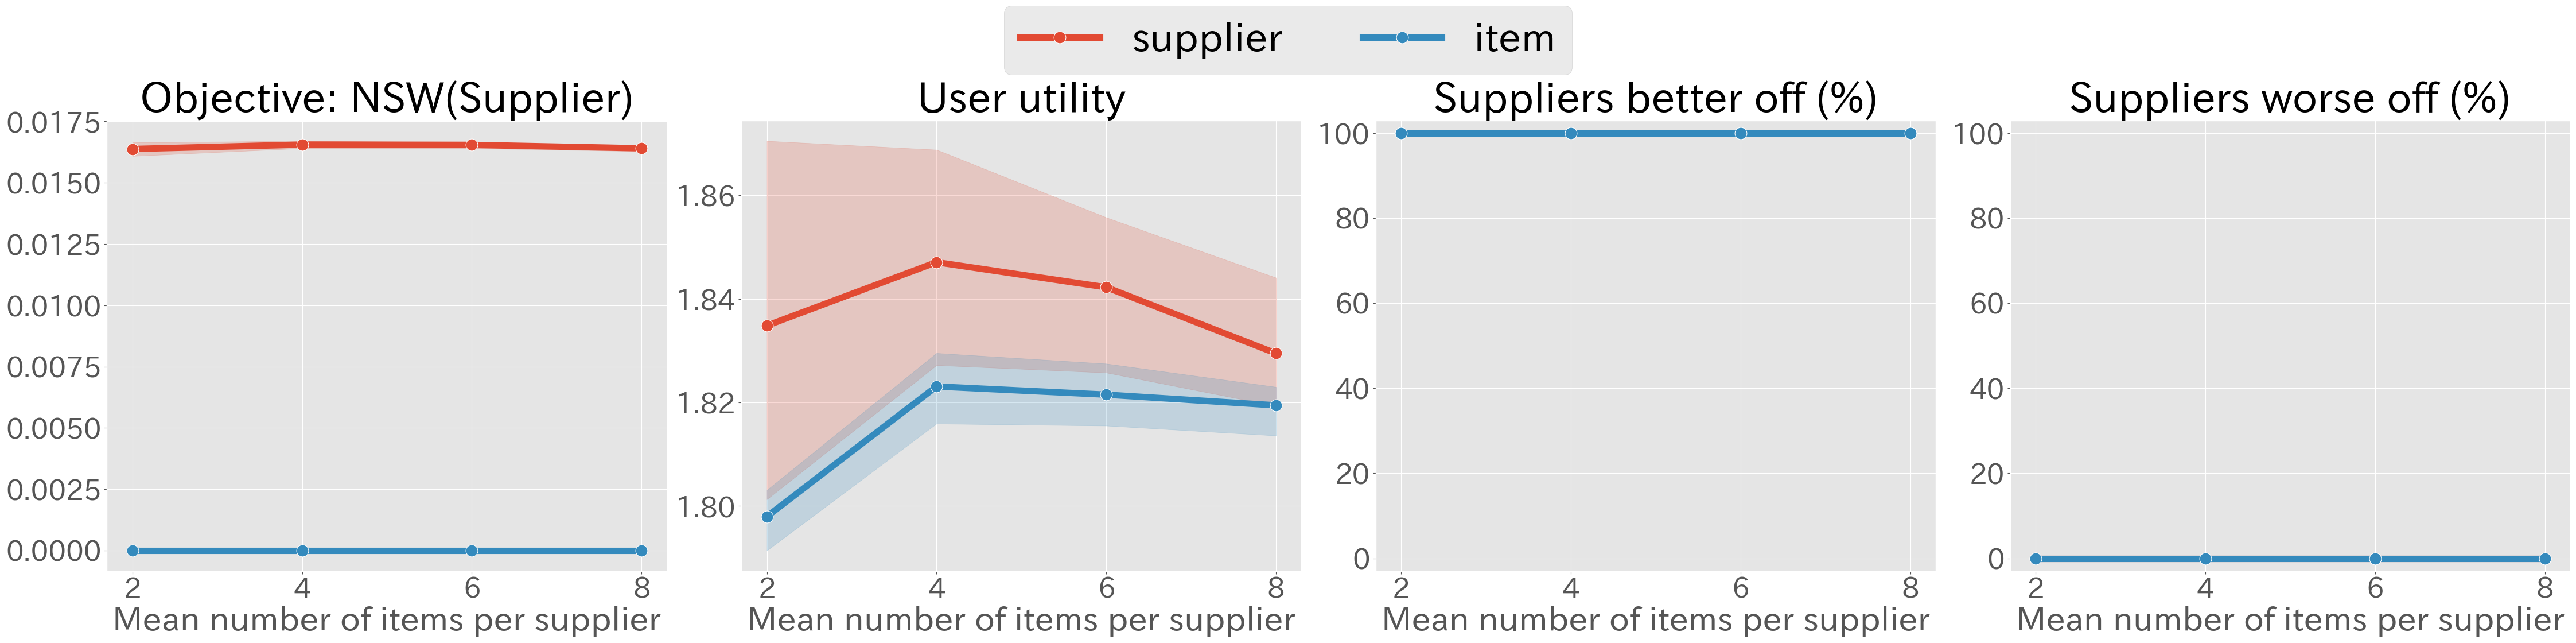

In [12]:
lam = 0.8
result = pd.DataFrame(results)
result["method"] = result["method"]
result = result.query("lam == @lam").reset_index(drop=True)

ncols = len(metrics)
figsize_0 = 45 / 4 * ncols
fig, axes = plt.subplots(ncols=ncols, figsize=(figsize_0, 10), tight_layout=True)
axes: list[Axes] = np.ravel(axes).tolist()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        x="mean_n_item_per_sup",
        y=metric,
        hue="method",
        data=result,
        ax=ax,
        marker="o",
        markersize=15,
        markers=True,
        linewidth=8,
        legend=True,
    )

    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("Mean number of items per supplier", fontsize=42)
    ax.tick_params(axis="both", labelsize=35)
    ax.legend(fontsize=35)

    if metric in ["pct_sup_util_better", "pct_sup_util_worse"]:
        ax.set_ylim(-3, 103)

    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

fig.legend(
    handles,
    labels,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(labels),
    loc="upper center",
)

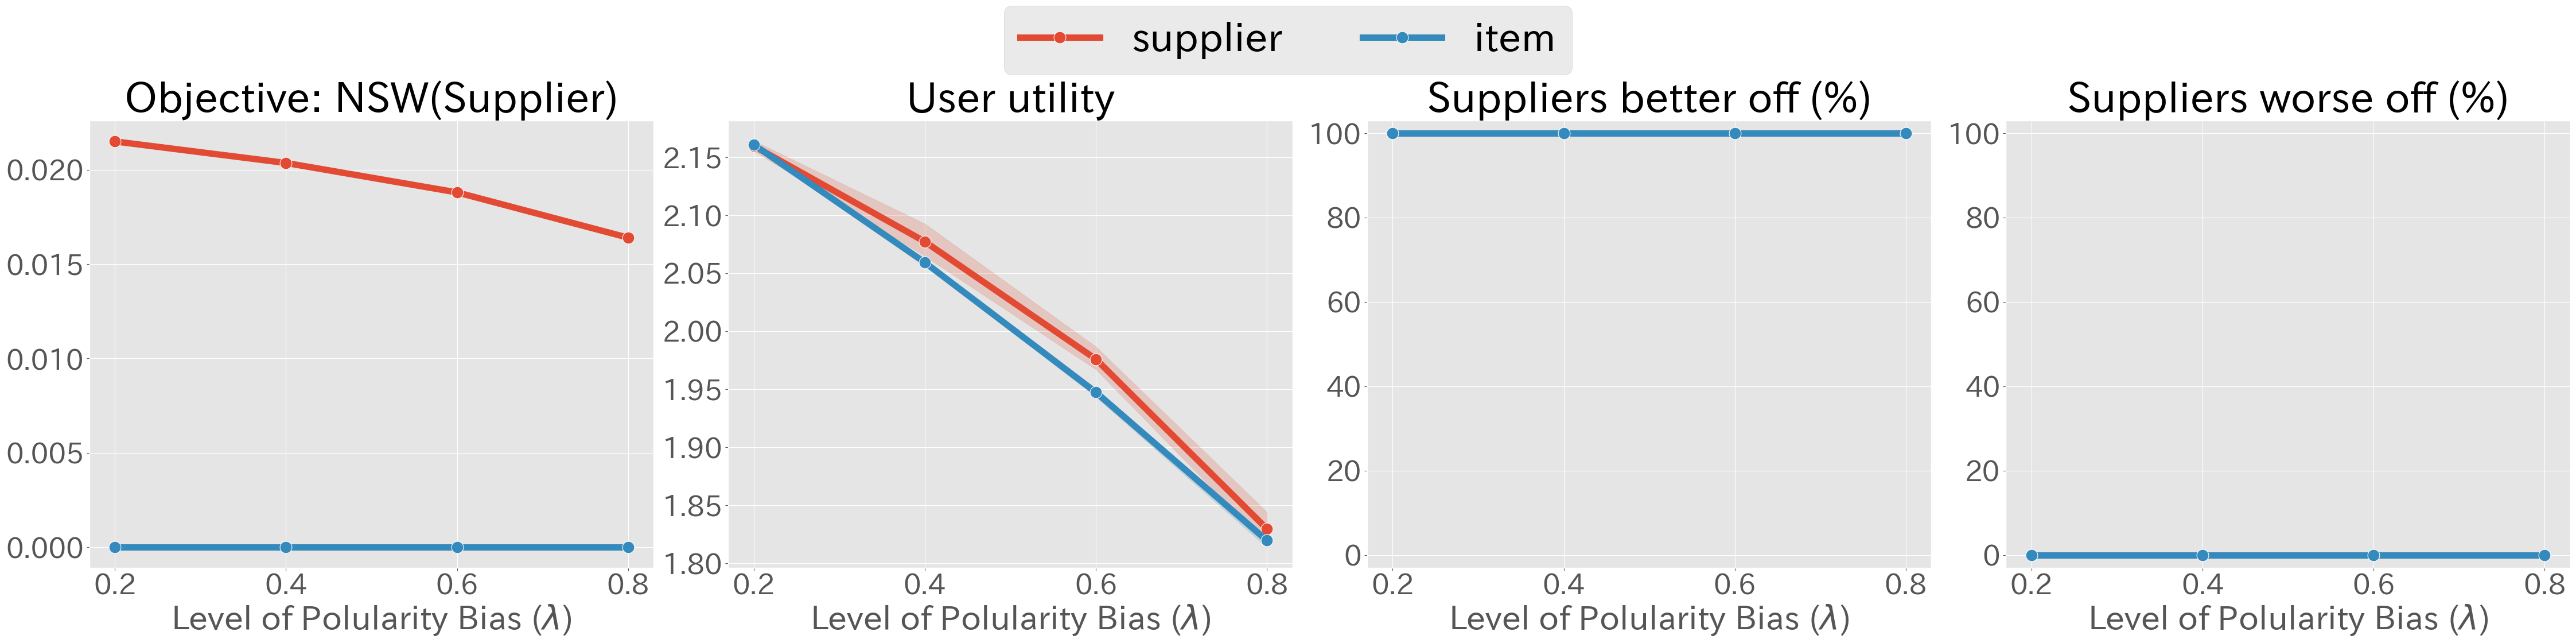

In [16]:
mean_n_item_per_sup = 8
result = pd.DataFrame(results)
result["method"] = result["method"]
result = result.query("mean_n_item_per_sup == @mean_n_item_per_sup").reset_index(drop=True)

ncols = len(metrics)
figsize_0 = 45 / 4 * ncols
fig, axes = plt.subplots(ncols=ncols, figsize=(figsize_0, 10), tight_layout=True)
axes: list[Axes] = np.ravel(axes).tolist()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        x="lam",
        y=metric,
        hue="method",
        data=result,
        ax=ax,
        marker="o",
        markersize=15,
        markers=True,
        linewidth=8,
        legend=True,
    )

    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("Level of Polularity Bias ($\lambda$)", fontsize=42)
    ax.tick_params(axis="both", labelsize=35)
    ax.legend(fontsize=35)

    if metric in ["pct_sup_util_better", "pct_sup_util_worse"]:
        ax.set_ylim(-3, 103)

    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

fig.legend(
    handles,
    labels,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(labels),
    loc="upper center",
)